# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [1]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "data/TP4_images/"


--2025-03-13 22:37:07--  https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip
Resolving nextcloud.lisn.upsaclay.fr (nextcloud.lisn.upsaclay.fr)... 129.175.8.8
Connecting to nextcloud.lisn.upsaclay.fr (nextcloud.lisn.upsaclay.fr)|129.175.8.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 678531 (663K) [application/zip]
Saving to: ‘north_dataset_train.zip’

north_dataset_train 100%[===================>] 662.63K  2.01MB/s    in 0.3s    

2025-03-13 22:37:08 (2.01 MB/s) - ‘north_dataset_train.zip’ saved [678531/678531]

Archive:  north_dataset_train.zip
   creating: north_dataset_sample/
   creating: north_dataset_sample/87/
  inflating: north_dataset_sample/87/haute-vienne_2500_0_0.jpeg  
  inflating: north_dataset_sample/87/haute-vienne_2500_10_0.jpeg  
  inflating: north_dataset_sample/87/haute-vienne_2500_11_0.jpeg  
  inflating: north_dataset_sample/87/haute-vienne_2500_12_0.jpeg  
  inflating: north_dataset_sample/

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix
# you can install torchmetrics with `pip install torchmetrics`
dir_path = "data/TP4_images/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

/home/bernas/.pyenv/versions/3.11.0/envs/MVA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [2]:
# Hint 
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)

In [4]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

In [3]:
from utils import precompute_features
from utils import train

Please, be sure to provide the full model (not just the feature extractor) as this function expects a model with a last layer.
Please, be sure to provide the full model (not just the feature extractor) as this function expects a model with a last layer.
Using device: cuda
Linear(in_features=512, out_features=2, bias=True)
Epoch 1/15 with validation loss: 1.0986320972442627 and accuracy: 0.328125
Epoch 6/15 with validation loss: 1.3213086128234863 and accuracy: 0.328125
Epoch 11/15 with validation loss: 0.8177588582038879 and accuracy: 0.328125


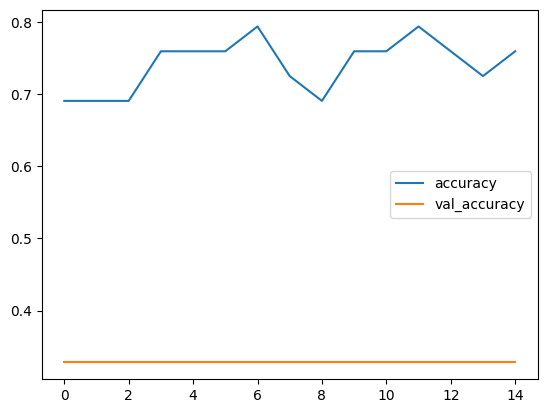

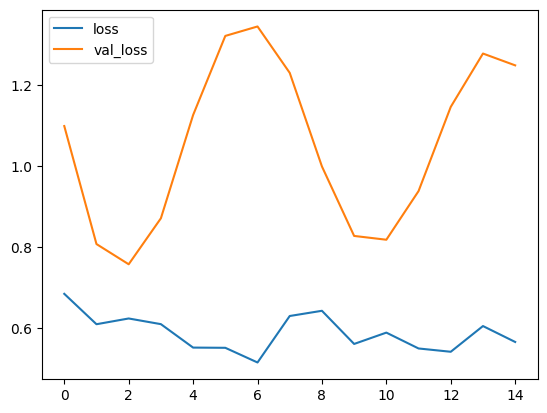

Linear(in_features=512, out_features=2, bias=True)

In [6]:
precomputed_dataset = precompute_features(base_model, north_dataset, device)
precomputed_test_dataset = precompute_features(base_model, test_dataset, device)

train_loader = torch.utils.data.DataLoader(precomputed_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(precomputed_test_dataset, batch_size=32, shuffle=False)

last_layer = base_model.fc
print(last_layer)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train(last_layer, train_loader, criterion, optimizer, device, num_epochs=15, val_loader=test_loader, num_classes=2)


<div class="alert alert-info">
  A first observation we can make is that, while the training accuracy is relatievely acceptable (above 70%), the test accuracy is really bad. This could have been expected, indeed, we are currently training the head of a model with randomly initialized weight. While we can try to fit the training data correctly, the model generalization capacity is really low. Thus resulting in low accuracy for the test data. To be clearer, the model did not fitt well the training data because it "understood" them but only because of overfitting. Therefore, when faced with new data, the model is not able to extracts correct features and yields low accuracy.
</div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

Please, be sure to provide the full model (not just the feature extractor) as this function expects a model with a last layer.
Please, be sure to provide the full model (not just the feature extractor) as this function expects a model with a last layer.
---------------------------------------- Train ----------------------------------------
Original test accuracy:
Accuracy: 0.6041666865348816
LastLayer(
  (linear): Linear(in_features=512, out_features=2, bias=True)
)
Using device: cuda
Please, be sure that you have provided the orignal test data and not the precomputed one.
Epoch 1/1000 with validation loss: 1.1751985549926758 and accuracy: 0.4375
Epoch 51/1000 with validation loss: 0.8337352275848389 and accuracy: 0.4833333492279053
Epoch 101/1000 with validation loss: 0.9311463832855225 and accuracy: 0.4958333373069763
Epoch 151/1000 with validation loss: 0.755598247051239 and accuracy: 0.5708333253860474
Epoch 201/1000 with validation loss: 0.7990581393241882 and accuracy: 0.57083332

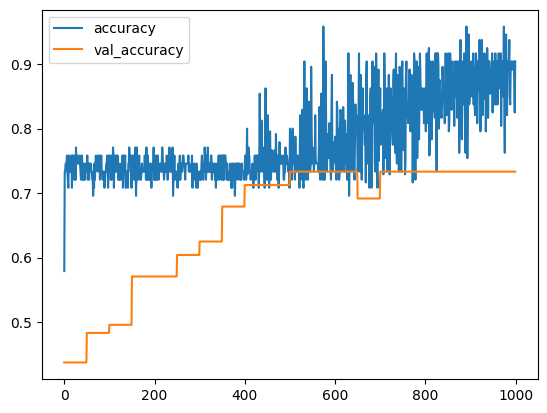

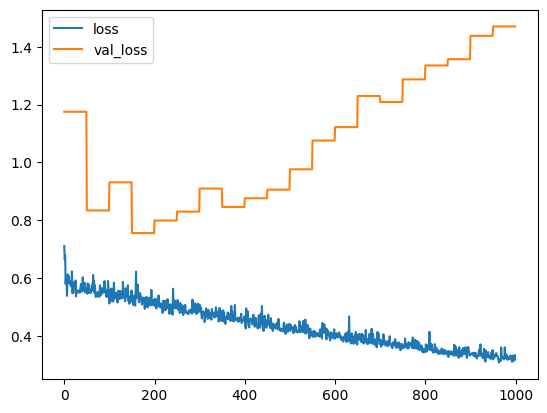

Final test accuracy:
Accuracy: 0.7333333492279053


In [7]:
from utils import LastLayer
from utils import evaluate
from utils import precompute_features
from utils import train

resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()

precomputed_dataset = precompute_features(resnet, north_dataset, device)
precomputed_test_dataset = precompute_features(resnet, test_dataset, device)

train_loader = torch.utils.data.DataLoader(precomputed_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(precomputed_test_dataset, batch_size=16, shuffle=False)
true_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
resnet.fc = fc
print("-"*40 + " Train " + "-"*40)
print("Original test accuracy:")
evaluate(resnet, true_test_loader, device, num_classes=2)

print(fc)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train(fc, train_loader, criterion, optimizer, device, num_epochs=1000, val_loader=true_test_loader, num_classes=2, print_every=50, original_model = resnet)

torch.save(fc.state_dict(), "last_layer_finetune.pth")

resnet.fc = fc
print("Final test accuracy:")
evaluate(resnet, true_test_loader, device, num_classes=2)

In [35]:
from utils import LastLayer


resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

<div class="alert alert-info">  
    LoRA is a method developed to perform cheap fine-tuning. The main idea is to get a pre-trained model on which you will add small rank matrix to some of the weight and will train on those matrix (you just need to train the weight of two smaller matrix and then take their product). As detailed in the paper, their main intuition is that "low intrinsic rank" matrix play a role in the learning process (when doing fine-tuning). Using the same notation as in the paper we can write that for a layer of weight W, we introduced two matrix B and A. The new weight used in our LoRA model will be : 
    
    W' = W + e*BA     where rank(BA)=r
</div>

$W\in \mathbb{R}^{N_1\times N_2},$
$B\in \mathbb{R}^{N_1 \times r},$
$A\in \mathbb{R}^{r \times N_2} \;:$
$$W' = W + \frac{\alpha}{r} BA $$

<div class="alert alert-info">
    Obviously, there is multiple other ways to obtain a matrix of rank r. Thus, in the specific case of convolution, their is different method that we can use. Find in the file `drawing_lora.png` the process chosen here.
</div>

![Lora drawing](drawing_lora.png)

In [21]:
import loralib as lora

class lora_conversion:
    def __init__(self, model, rank, alpha, type="conv2d"):
        self.model = model
        self.rank = rank
        self.alpha = alpha
        self.type = type

    def lora_module_load(self, module, verbose=False):
        for name, child in module.named_children():
            if isinstance(child, nn.Conv2d) and self.type == "conv2d":
                lora_conv = self.lora_conv2d(child)
                setattr(module, name, lora_conv)
            elif isinstance(child, nn.Linear) and self.type == "linear":
                lora_linear = self.lora_linear(child)
                setattr(module, name, lora_linear)
            else:
                if verbose:
                    print("Skip layer", name)
            self.lora_module_load(child)

    def lora_conv2d(self, layer):
        in_channels = layer.in_channels
        out_channels = layer.out_channels
        kernel_size = layer.kernel_size[0]
        stride = layer.stride
        padding = layer.padding
        dilation= layer.dilation
        groups = layer.groups
        bias = (layer.bias is not None)
        lora_layer = lora.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
                r=self.rank,
                lora_alpha=self.alpha
            )
        # copy original weights & bias 
        lora_layer.conv.weight.data.copy_(layer.weight.data)
        if bias:
            lora_layer.conv.bias.data.copy_(layer.bias.data)
        return lora_layer
    
    def lora_linear(self, layer):
        in_features = layer.in_features
        out_features = layer.out_features
        bias = (layer.bias is not None)
        lora_layer = lora.Linear(in_features, out_features, r=self.rank, lora_alpha=self.alpha)
        # copy original weights & bias 
        lora_layer.weight.data.copy_(layer.weight.data)
        if bias:
            lora_layer.bias.data.copy_(layer.bias.data)
        return lora_layer
    
    def convert(self, list_of_layers = None, verbose=False):
        if list_of_layers is None:
            list_of_layers = [self.model]
        for layer in list_of_layers:
            self.lora_module_load(layer, verbose=verbose)
        return self.model
    
    def merging(self, module):
        for name, child in module.named_children():
            if isinstance(child, lora.Conv2d) and self.type == "conv2d":
                origin_conv = self.merge_conv2d(child)
                setattr(module, name, origin_conv)
            elif isinstance(child, lora.Linear) and self.type == "linear":
                origin_linear = self.merge_linear(child)
                setattr(module, name, origin_linear)
            else:
                self.merging(child)

    def merge(self, list_of_layers = None):
        if list_of_layers is None:
            list_of_layers = [self.model]
        for layer in list_of_layers:
            self.merging(layer)
        return self.model
    
    def merge_conv2d(self, layer):
        conv = nn.Conv2d(
            in_channels=layer.conv.in_channels,
            out_channels=layer.conv.out_channels,
            kernel_size=layer.conv.kernel_size,
            stride=layer.conv.stride,
            padding=layer.conv.padding,
            dilation=layer.conv.dilation,
            groups=layer.conv.groups,
            bias=(layer.conv.bias is not None)
        )
        if not layer.merged:
            layer.merge_weights = True
            layer.train(mode=False)
        conv.weight.data.copy_(layer.conv.weight.data)
        return conv
        
    def merge_linear(self, layer):
        linear = nn.Linear(
            in_features=layer.in_features,
            out_features=layer.out_features,
            bias=(layer.bias is not None)
        )
        if not layer.merged:
            layer.merge_weights = True
            layer.train(mode=False)
        linear.weight.data.copy_(layer.weight.data)
        return linear

In [5]:
from utils import LastLayer
from utils import evaluate
from utils import precompute_features
from utils import train

Skip layer 0
Skip layer bn1
Skip layer relu
Skip layer bn2
Skip layer downsample
Skip layer 1
Skip layer 1
Skip layer bn1
Skip layer relu
Skip layer bn2
Skip layer 0
Skip layer bn1
Skip layer relu
Skip layer bn2
Skip layer downsample
Skip layer 1
Skip layer 1
Skip layer bn1
Skip layer relu
Skip layer bn2
Using device: cuda
Epoch 1/100 with validation loss: 0.5340985059738159 and accuracy: 0.8125
Epoch 51/100 with validation loss: 0.759958028793335 and accuracy: 0.8416666984558105


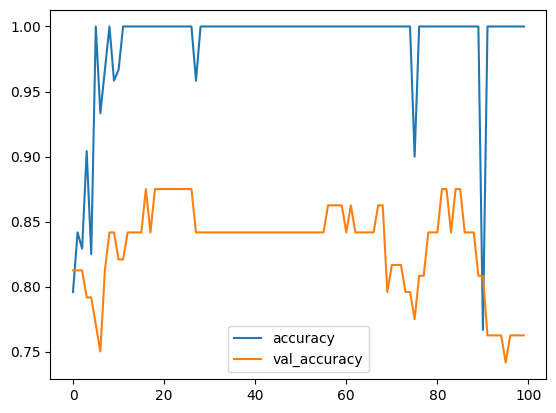

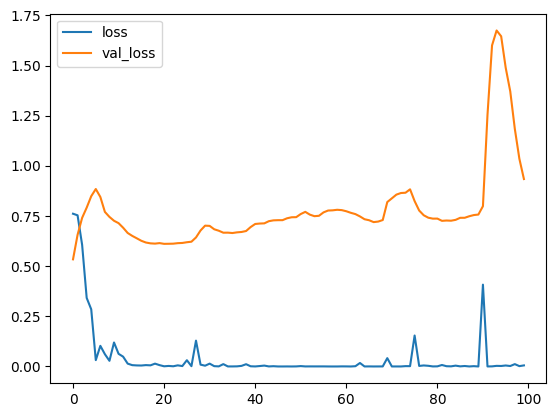

In [38]:
resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc

LoRA = lora_conversion(resnet, rank=8, alpha=1.0, type="conv2d")
list_of_layers = [resnet.layer3, resnet.layer4] # resnet.conv1, resnet.layer1, resnet.layer2,
resnet = LoRA.convert(list_of_layers, verbose=True)
lora.mark_only_lora_as_trainable(resnet)

train_loader = torch.utils.data.DataLoader(north_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
train(resnet, train_loader, criterion, optimizer, device, num_epochs=100, val_loader=test_loader, num_classes=2, print_every=10)

torch.save(lora.lora_state_dict(resnet), 'lora_test.pth')


In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc


evaluate(resnet, test_loader, device, num_classes=2)

LoRA = lora_conversion(resnet, rank=8, alpha=1.0, type="conv2d")
list_of_layers = [resnet.layer3, resnet.layer4] # resnet.conv1, resnet.layer1, resnet.layer2,
resnet = LoRA.convert(list_of_layers)

resnet.load_state_dict(torch.load('lora_test.pth'), strict=False)

evaluate(resnet, test_loader, device, num_classes=2)

Accuracy: 0.8958333134651184


/tmp/ipykernel_6046/2831240724.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('lora_test.pth'), strict=False)


Accuracy: 0.862500011920929


## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

<div class="alert alert-info">
    I will be refering to CutMix process introduced in "CutMix: Regularization Strategy to Train Strong Classifiers
    with Localizable Features" Sangdoo Yun et al. The main idea behind CutMix is to mix images is with each others using patches. To be more precise, first you randomly sample a patch scale coefficient (lambda sampled between 0 to 1) which will give you a size for your patch. Then, you extract a patch of the fixed size obtained at the precedent step from an image (with the center of the patch being randomly chosen) and then you add it to another image. The new image created will be labeled as a interpolation of the two images original label where the interpolation coefficient is based on the scale (lambda) of the patch (it means that the bigger the patch is the nearer the weight of the cropped image is from 1 and in the other sense, the nearer it is from 0). In the cell bellow you can find the exact formula processed in the paper.
</div>

Formula used to compute CutMix as suggested in the original paper :
$$\lambda \sim \mathcal{U}(0,1),$$
$$\tilde{x} = \mathbf{M} \odot x_A + (1 - \mathbf{M}) \odot x_B,$$
$$\tilde{y} = \lambda y_A + (1 - \lambda) y_B,$$
$$r_x \sim \mathcal{U}(0, W), \quad r_w = W \sqrt{1 - \lambda},$$
$$r_y \sim \mathcal{U}(0, H), \quad r_h = H \sqrt{1 - \lambda},$$
$$\frac{r_w r_h}{W H} = 1 - \lambda \quad \text{ (Link between the patch scale and the image B label impact on final labeling)}.$$

![Cutmix](cutmix.png)

In [7]:
from utils import LastLayer
from utils import evaluate
from utils import train

Skip layer 0
Skip layer 1
Skip layer 0
Skip layer 1
Using device: cuda
It is recommended to not use data augmentation with precomputed features.
Epoch 1/500 with validation loss: 0.5202088356018066 and accuracy: 0.8333333730697632
Epoch 11/500 with validation loss: 0.6624289155006409 and accuracy: 0.7875000238418579
Epoch 21/500 with validation loss: 0.4530336260795593 and accuracy: 0.8000000715255737
Epoch 31/500 with validation loss: 0.4584617018699646 and accuracy: 0.7666666507720947
Epoch 41/500 with validation loss: 0.5249781012535095 and accuracy: 0.7458333373069763
Epoch 51/500 with validation loss: 0.890934944152832 and accuracy: 0.7416666746139526
Epoch 61/500 with validation loss: 0.6515357494354248 and accuracy: 0.762499988079071
Epoch 71/500 with validation loss: 0.4150334298610687 and accuracy: 0.8500000238418579
Epoch 81/500 with validation loss: 0.683626651763916 and accuracy: 0.7750000357627869
Epoch 91/500 with validation loss: 0.4378739595413208 and accuracy: 0.850000

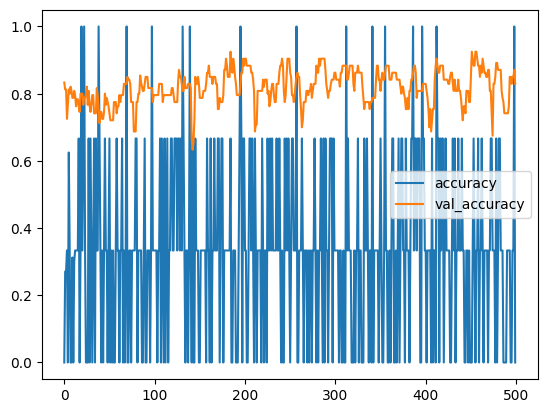

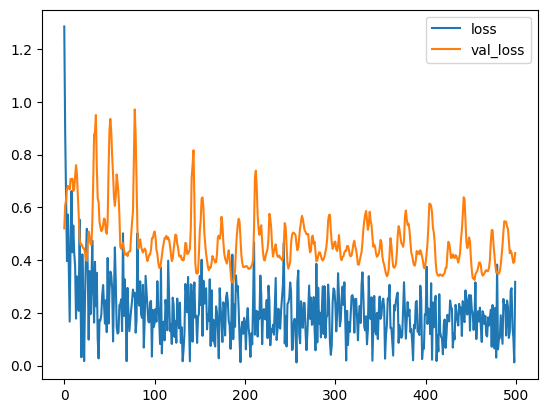

Accuracy: 0.8291666507720947
Accuracy: 0.8291666507720947


In [8]:
## Data Augmentation
import torchvision.transforms.v2 as v2

NUM_CLASSES = 2
pre_trained = False

cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
identity = v2.Identity()  # To also train on the original images

cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

if pre_trained:
    resnet = models.resnet18(weights="DEFAULT")
    fc = LastLayer()
    resnet.fc = fc
    resnet.load_state_dict(torch.load("daug_resnet.pth", weights_only=True))
else:
    resnet = models.resnet18(weights="DEFAULT")
    fc = LastLayer()
    fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
    resnet.fc = fc

LoRA = lora_conversion(resnet, rank=16, alpha=4.0, type="conv2d")
list_of_layers = [resnet.layer3, resnet.layer4] # resnet.conv1, resnet.layer1, resnet.layer2,
resnet = LoRA.convert(list_of_layers, verbose=True)
lora.mark_only_lora_as_trainable(resnet)

train_loader = torch.utils.data.DataLoader(north_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
train(resnet, train_loader, criterion, optimizer, device, num_epochs=500, val_loader=test_loader, num_classes=2, print_every=10, augment_fn=cutmix_or_mixup, keep_best=True)

torch.save(lora.lora_state_dict(resnet), 'lora_test.pth')

evaluate(resnet, test_loader, device, num_classes=2)

lora_model = LoRA.merge()
torch.save(lora_model.state_dict(), "daug_resnet.pth")
assert isinstance(lora_model, models.ResNet)
evaluate(lora_model, test_loader, device, num_classes=2)

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc


evaluate(resnet, test_loader, device, num_classes=2)

resnet.load_state_dict(torch.load('daug_resnet.pth', weights_only=True))

evaluate(resnet, test_loader, device, num_classes=2)

Accuracy: 0.8958333134651184
Accuracy: 0.8291666507720947


## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 

Skip layer 0
Skip layer 1
Skip layer 0
Skip layer 1
Skip layer 0
Skip layer 1
Skip layer 0
Skip layer 1
Using device: cuda
It is recommended to not use data augmentation with precomputed features.
Epoch 1/500 with validation loss: 0.4267861843109131 and accuracy: 0.8291666507720947
Epoch 11/500 with validation loss: 0.45452880859375 and accuracy: 0.8291666507720947
Epoch 21/500 with validation loss: 0.46052297949790955 and accuracy: 0.8291666507720947
Epoch 31/500 with validation loss: 0.46689915657043457 and accuracy: 0.8291666507720947
Epoch 41/500 with validation loss: 0.4667675197124481 and accuracy: 0.8083333373069763
Epoch 51/500 with validation loss: 0.46863454580307007 and accuracy: 0.7875000238418579
Epoch 61/500 with validation loss: 0.4625488221645355 and accuracy: 0.8083333373069763
Epoch 71/500 with validation loss: 0.4917171895503998 and accuracy: 0.7875000238418579
Epoch 81/500 with validation loss: 0.4628969132900238 and accuracy: 0.8291666507720947
Epoch 91/500 with va

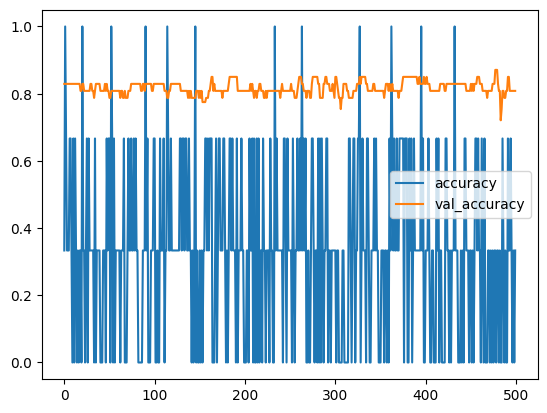

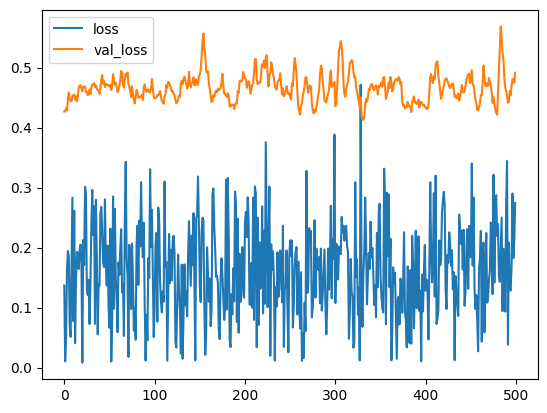

Best model with accuracy: 0.8708333373069763
Accuracy: 0.8708333373069763
Accuracy: 0.8708333373069763
Accuracy: 0.8708333373069763
Skip layer 0
Skip layer 1
Skip layer 0
Skip layer 1
It is recommended to not use data augmentation with precomputed features.
Epoch 1/500 with validation loss: 0.4307224154472351 and accuracy: 0.8500000238418579
Epoch 11/500 with validation loss: 0.4268045425415039 and accuracy: 0.8291666507720947
Epoch 21/500 with validation loss: 0.3616889417171478 and accuracy: 0.9041666984558105
Epoch 31/500 with validation loss: 0.5234840512275696 and accuracy: 0.7541667222976685
Epoch 41/500 with validation loss: 0.40733861923217773 and accuracy: 0.8500000238418579
Epoch 51/500 with validation loss: 0.4814026355743408 and accuracy: 0.8083333373069763
Epoch 61/500 with validation loss: 0.4856751561164856 and accuracy: 0.8083333373069763
Epoch 71/500 with validation loss: 0.44692105054855347 and accuracy: 0.8083333373069763
Epoch 81/500 with validation loss: 0.41067498

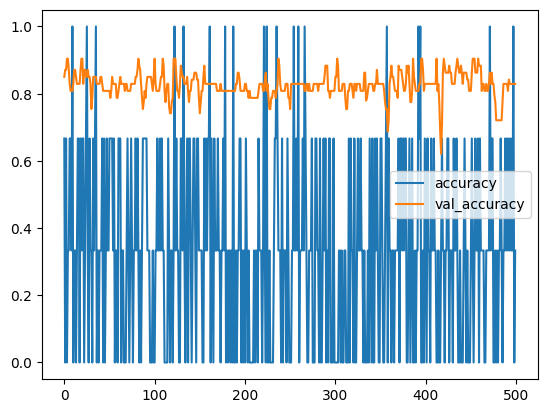

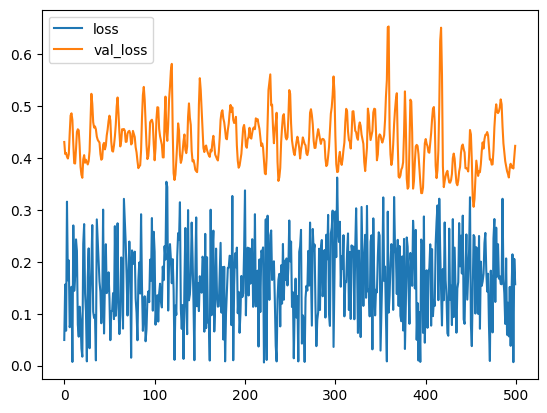

Best model with accuracy: 0.9041666984558105
Accuracy: 0.9041666984558105
Accuracy: 0.9041666984558105
Accuracy: 0.9041666984558105


In [32]:
## Data Augmentation
import torchvision.transforms.v2 as v2

NUM_CLASSES = 2
pre_trained = True

cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
identity = v2.Identity()  # To also train on the original images

cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

if pre_trained:
    resnet = models.resnet18(weights="DEFAULT")
    fc = LastLayer()
    resnet.fc = fc
    resnet.load_state_dict(torch.load("daug_resnet.pth", weights_only=True))
else:
    resnet = models.resnet18(weights="DEFAULT")
    fc = LastLayer()
    fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
    resnet.fc = fc

### First, we will LoRA fine-tune on the linear layers of our resnet model
LoRA = lora_conversion(resnet, rank=32, alpha=4.0, type="linear")
list_of_layers = [resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4, resnet.fc]
resnet = LoRA.convert(list_of_layers, verbose=True)
lora.mark_only_lora_as_trainable(resnet)

train_loader = torch.utils.data.DataLoader(north_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
resnet = train(resnet, train_loader, criterion, optimizer, device, num_epochs=500, val_loader=test_loader, num_classes=2, print_every=10, augment_fn=cutmix_or_mixup, keep_best=True)

evaluate(resnet, test_loader, device, num_classes=2)

LoRA.model = resnet
lora_model = LoRA.merge()
torch.save(lora_model.state_dict(), "final_resnet.pth")
assert isinstance(lora_model, models.ResNet)
evaluate(lora_model, test_loader, device, num_classes=2)

LoRA = lora_conversion(lora_model, rank=16, alpha=2.0, type="conv2d")
list_of_layers = [lora_model.layer3, lora_model.layer4]
resnet = LoRA.convert(list_of_layers, verbose=True)
lora.mark_only_lora_as_trainable(resnet)

optimizer = torch.optim.Adam(lora_model.parameters(), lr=0.001)
lora_model = train(lora_model, train_loader, criterion, optimizer, device, num_epochs=500, val_loader=test_loader, num_classes=2, print_every=10, augment_fn=cutmix_or_mixup, keep_best=True)

evaluate(lora_model, test_loader, device, num_classes=2)

LoRA.model = lora_model
lora_model = LoRA.merge()
torch.save(lora_model.state_dict(), "final_model.pth")
assert isinstance(lora_model, models.ResNet)
evaluate(lora_model, test_loader, device, num_classes=2)

In [34]:
resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc

print("Best model without LoRA fine-tuning:")
evaluate(resnet, test_loader, device, num_classes=2)

resnet.load_state_dict(torch.load('final_model.pth', weights_only=True))

print("Best model with LoRA fine-tuning:")
evaluate(resnet, test_loader, device, num_classes=2)

Best model without LoRA fine-tuning:
Accuracy: 0.8958333134651184
Best model with LoRA fine-tuning:
Accuracy: 0.9041666984558105
